### Step 1: Import the required Python libraries

In [1]:
import tensorflow
print(f"tensorflow {tensorflow.__version__}")
import numpy
print(f"numpy {numpy.__version__}")
import matplotlib.pyplot

tensorflow 2.15.0
numpy 1.25.2


### Step 2: Load the data

In [2]:
(X_train, y_train), (X_validate, y_validate) = tensorflow.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [3]:
# encourage the discriminator to be less confident when classifying real samples

def smooth_labels(labels, smoothing=0.1):
    # Move the values down from 1 (labels * (1 - smoothing))
    # Move the values up from 0 (+ 0.5 * smoothing)
    return labels * (1 - smoothing) + 0.5 * smoothing


In [4]:
y_train

label_dictionary = {
  0: "airplane",
  1: "automobile",
  2: "bird",
  3: "cat",
  4: "deer",
  5: "dog",
  6: "frog",
  7: "horse",
  8: "ship",
  9: "truck"
}

label_dictionary[y_train[0][0]]

'frog'

In [5]:
image_class_number = 8
indicies_for_class_number = y_train.flatten() == image_class_number
X = X_train[indicies_for_class_number]
y = y_train[indicies_for_class_number]

array([[[134, 186, 223],
        [131, 184, 220],
        [128, 182, 218],
        ...,
        [127, 181, 222],
        [127, 181, 222],
        [128, 182, 223]],

       [[133, 189, 228],
        [129, 186, 224],
        [128, 186, 224],
        ...,
        [127, 183, 224],
        [127, 183, 224],
        [128, 184, 225]],

       [[128, 185, 226],
        [127, 182, 223],
        [128, 182, 223],
        ...,
        [126, 181, 222],
        [126, 181, 222],
        [126, 180, 221]],

       ...,

       [[174, 208, 235],
        [171, 206, 229],
        [155, 189, 216],
        ...,
        [ 27,  94, 136],
        [ 29,  96, 137],
        [ 28,  94, 136]],

       [[194, 221, 244],
        [189, 215, 239],
        [159, 196, 225],
        ...,
        [ 30,  95, 138],
        [ 30,  96, 139],
        [ 30,  95, 140]],

       [[193, 217, 237],
        [181, 208, 230],
        [168, 201, 227],
        ...,
        [ 31,  94, 136],
        [ 32,  94, 137],
        [ 32,  94, 138]]], dtype=uint8)
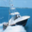

In [6]:
X[0]

In [7]:
y

array([[8],
       [8],
       [8],
       ...,
       [8],
       [8],
       [8]], dtype=uint8)

### Step 3: Define parameters to be used in later processes

In [8]:
image_shape = (32, 32, 3)
latent_dimensions = 100

### Step 4: Define a utility function to build the generator

In [9]:
def build_generator(latent_dimensions):
    return tensorflow.keras.Sequential([
        tensorflow.keras.layers.Dense(128 * 8 * 8, activation="relu", input_dim=latent_dimensions),
        tensorflow.keras.layers.Reshape((8,8,128)),
        tensorflow.keras.layers.UpSampling2D(),
        tensorflow.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same"),
        tensorflow.keras.layers.BatchNormalization(momentum=0.78),
        tensorflow.keras.layers.Activation("relu"),
        tensorflow.keras.layers.UpSampling2D(),
        tensorflow.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same"),
        tensorflow.keras.layers.BatchNormalization(momentum=0.78),
        tensorflow.keras.layers.Activation("relu"),
        tensorflow.keras.layers.Conv2D(filters=3, kernel_size=3, padding="same"),
        tensorflow.keras.layers.BatchNormalization(momentum=0.78),
        tensorflow.keras.layers.Activation("tanh"),
    ])

    # # Generating the output image
    # noise = tensorflow.keras.Input(shape=(latent_dimensions,))
    # image = model(noise)
    # return tensorflow.keras.Model(noise, image)

### Step 5: Define a utility function to build the discriminator

In [10]:
def build_discriminator():
    model = tensorflow.keras.Sequential([
        tensorflow.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"),
        tensorflow.keras.layers.LeakyReLU(alpha=0.2),
        tensorflow.keras.layers.Dropout(0.25),
        tensorflow.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same"),
        tensorflow.keras.layers.ZeroPadding2D(padding=((0,1),(0,1))),
        tensorflow.keras.layers.BatchNormalization(momentum=0.82),
        tensorflow.keras.layers.LeakyReLU(alpha=0.25),
        tensorflow.keras.layers.Dropout(0.25),
        tensorflow.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same"),
        tensorflow.keras.layers.BatchNormalization(momentum=0.82),
        tensorflow.keras.layers.LeakyReLU(alpha=0.2),
        tensorflow.keras.layers.Dropout(0.25),
        tensorflow.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same"),
        tensorflow.keras.layers.BatchNormalization(momentum=0.8),
        tensorflow.keras.layers.LeakyReLU(alpha=0.25),
        tensorflow.keras.layers.Dropout(0.25),
        tensorflow.keras.layers.Flatten(),
        tensorflow.keras.layers.Dense(1, activation='sigmoid')
    ])

    image = tensorflow.keras.layers.Input(shape=image_shape)

    # image should be a tensor output from a layer, not a numpy array or a scalar
    validity = model(image)

    # Creating the Functional model correctly
    return tensorflow.keras.Model(inputs=image, outputs=validity)


### Step 6: Define a utility function to display the generated images

In [11]:
def display_images(generator):
    rows, columns = 4, 4
    noise = numpy.random.normal(0,1, (rows * columns, latent_dimensions))
    generated_images = generator.predict(noise)

    # Reset the pixels to their values between [0,1]
    generated_images = 0.5 * generated_images + 0.5

    figure, axes = matplotlib.pyplot.subplots(rows, columns)
    count = 0
    for i in range(rows):
        for j in range(columns):
            axes[i,j].imshow(generated_images[count, :,:,])
            axes[i,j].axis('off')
            count += 1
    matplotlib.pyplot.show()
    matplotlib.pyplot.close()

### Step 7: Build the GAN

In [12]:
learning_rate_discriminator = 0.0003
learning_rate_generator = 0.0001

def learning_rate_schedule(initial_learning_rate):
  return tensorflow.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate,
      decay_steps=10000,
      decay_rate=0.96,
      staircase=True)

In [13]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate_discriminator, beta_1=0.5), metrics=['accuracy'])
discriminator.trainable = False

In [14]:
generator = build_generator(latent_dimensions)

In [15]:
# Defining the input for the generator and generating the images
z = tensorflow.keras.layers.Input(shape=(latent_dimensions,))
image = generator(z)

#Check the validity of the generated image
valid = discriminator(image)

#Defining the combined model of the generator and the discriminator
combined_network = tensorflow.keras.Model(z, valid)
combined_network.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate_schedule(learning_rate_generator), beta_1=0.5))

#### Model checks

In [16]:
def generate_image(random_latent_vectors):
  if random_latent_vectors is None:
    random_latent_vectors = tensorflow.random.normal(shape=(1, latent_dimensions))

  # Use the generator to create an image from the random latent vector
  generated_image = generator(random_latent_vectors)

  # Post-process the image
  generated_image = (generated_image * 127.5 + 127.5).numpy().astype(numpy.uint8)  # Scale from [-1,1] to [0,255]

  return generated_image

In [17]:
def display(image):

  if len(image.shape) == 4:
    # needs to be converted to a image batch of 1
    image = tensorflow.squeeze(image, axis=0)
  matplotlib.pyplot.imshow(image)
  matplotlib.pyplot.axis('off')  # Turn off axis numbers and ticks
  matplotlib.pyplot.show()


In [18]:
def test_if_real(image):
  if len(image.shape) == 3:
    # needs to be converted to a image batch of 1
    image = tensorflow.expand_dims(image, axis=0)
  is_real = discriminator.predict(image)
  probability = is_real[0][0]
  percentage = round(probability * 100, 2)
  print(f'{percentage}% certain this image is real')
  display(image)
  return is_real


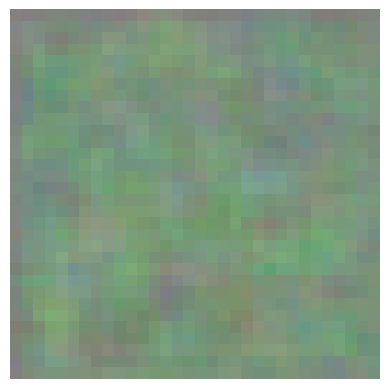

In [19]:
random_latent_vectors = tensorflow.random.normal(shape=(1, latent_dimensions))
generated_image_batch = generate_image(random_latent_vectors)
display(generated_image_batch[0])

1/1 [==============================] - 1s 835ms/step
64.98% certain this image is real


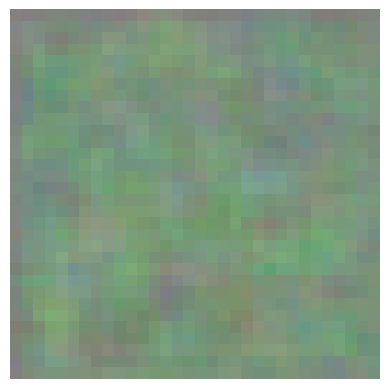

In [20]:
# Check if the discriminator thinks it is real
is_real = test_if_real(generated_image_batch)


### Step 8: Train the network

In [32]:
import time

def train(X):
  number_of_epochs = 1500
  batch_size = 32
  display_interval = 500
  log_interval = 50
  real_image_max_confidence = 0.9
  losses = []

  # normalize the image pixel data from [0, 255] to between [-1, 1]
  X = X / 255 * 2 - 1

  # Define the Adversarial ground truths
  valid = numpy.ones((batch_size, 1))

  # Add some noise to help with generalization
  valid += 0.05 * numpy.random.random(valid.shape)

  # Smooth labels to help the discriminator to avoid becoming overly confident in its predictions
  valid = smooth_labels(valid, 0.1)

  fake = numpy.zeros((batch_size, 1))
  fake += 0.05 * numpy.random.random(fake.shape)

  file_name = f"losses_{time.time()}.txt"

  with open("losses.txt", "w") as file:
        file.write("Epoch,Discriminator Loss Real,Discriminator Loss Fake,Discriminator Loss,Generator Loss\n")

  for epoch in range(number_of_epochs):

      # Ensure the training happens on GPU
      with tensorflow.device('/GPU:0'):  # This specifies that the following operations should use the GPU

        # Train the discriminator

        # Sampling of random half of images
        indexes = numpy.random.randint(0, X.shape[0], batch_size)
        images = X[indexes]

        # Sampling noise and generating a batch of new images
        noise = numpy.random.normal(0, 1, (batch_size, latent_dimensions))
        generated_images = generator.predict(noise)

        # Train the discriminator to detect more accurately
        discriminator.trainable = True

        # encourage the discriminator to be less confident when classifying real samples
        discriminator_loss_real = discriminator.train_on_batch(images, valid)

        discriminator_loss_fake = discriminator.train_on_batch(generated_images, fake)
        discriminator_loss = 0.5 * numpy.add(discriminator_loss_real, discriminator_loss_fake)

        discriminator.trainable = False

        if epoch % 5 == 0:

          # Train the generator to make images that pass the discriminator
          generator_loss = combined_network.train_on_batch(noise, valid)
        else:
          generator_loss = "NA"

        # Tracking the progress
        if epoch % display_interval == 0 or epoch == number_of_epochs - 1:
            display_images(generator)

        if epoch % log_interval == 0 or epoch == number_of_epochs - 1:
          print(f"Epoch {epoch + 1}/{number_of_epochs}")
          print(f"Discriminator Loss: {discriminator_loss[0]}, Real Loss = {discriminator_loss_real[0]}, Fake Loss = {discriminator_loss_fake[0]}")
          print(f"Generator Loss: {generator_loss}")

          with open(file_name, "a") as file:
                file.write(f"{epoch},{discriminator_loss_real[0]},{discriminator_loss_fake[0]},{discriminator_loss[0]},{generator_loss}\n")



1/1 [==============================] - 0s 22ms/step


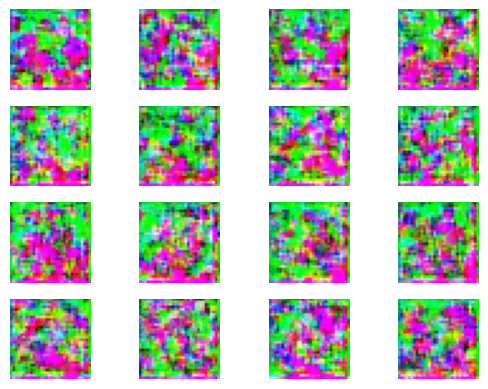

Epoch 1/1500
Discriminator Loss: 0.114619892090559, Real Loss = 0.11621200293302536, Fake Loss = 0.11302778124809265
Generator Loss: 1.0025520324707031
1/1 [==============================] - 0s 17ms/step
Epoch 51/1500
Discriminator Loss: 0.11610065400600433, Real Loss = 0.11691036820411682, Fake Loss = 0.11529093980789185
Generator Loss: 1.0462477207183838
1/1 [==============================] - 0s 21ms/step
Epoch 101/1500
Discriminator Loss: 0.11504751071333885, Real Loss = 0.11718416213989258, Fake Loss = 0.11291085928678513
Generator Loss: 1.0900239944458008
1/1 [==============================] - 0s 25ms/step
Epoch 151/1500
Discriminator Loss: 0.11584612354636192, Real Loss = 0.1176895797252655, Fake Loss = 0.11400266736745834
Generator Loss: 1.2248694896697998
1/1 [==============================] - 0s 17ms/step
Epoch 201/1500
Discriminator Loss: 0.11542205512523651, Real Loss = 0.11727899312973022, Fake Loss = 0.1135651171207428
Generator Loss: 1.3581938743591309
1/1 [==============

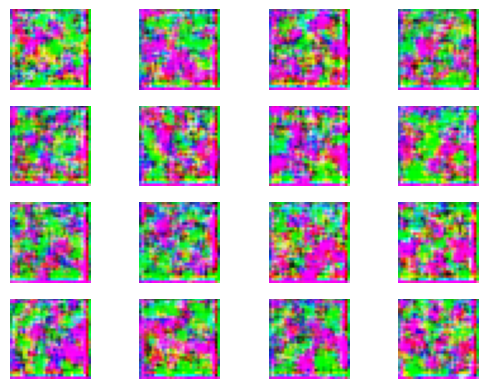

Epoch 501/1500
Discriminator Loss: 0.1151045560836792, Real Loss = 0.11799454689025879, Fake Loss = 0.11221456527709961
Generator Loss: 1.2987585067749023
1/1 [==============================] - 0s 18ms/step
Epoch 551/1500
Discriminator Loss: 0.11447174102067947, Real Loss = 0.11650553345680237, Fake Loss = 0.11243794858455658
Generator Loss: 1.1607348918914795
1/1 [==============================] - 0s 20ms/step
Epoch 601/1500
Discriminator Loss: 0.11589991301298141, Real Loss = 0.11825655400753021, Fake Loss = 0.11354327201843262
Generator Loss: 1.0423756837844849
1/1 [==============================] - 0s 23ms/step
Epoch 651/1500
Discriminator Loss: 0.11475053429603577, Real Loss = 0.11756028980016708, Fake Loss = 0.11194077879190445
Generator Loss: 0.9936008453369141
1/1 [==============================] - 0s 17ms/step
Epoch 701/1500
Discriminator Loss: 0.1151980422437191, Real Loss = 0.1169152483344078, Fake Loss = 0.1134808361530304
Generator Loss: 1.115578293800354
1/1 [============

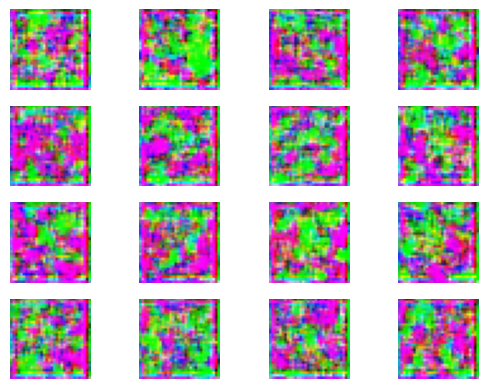

Epoch 1001/1500
Discriminator Loss: 0.11429857835173607, Real Loss = 0.11673655360937119, Fake Loss = 0.11186060309410095
Generator Loss: 1.4645572900772095
1/1 [==============================] - 0s 16ms/step
Epoch 1051/1500
Discriminator Loss: 0.11446763202548027, Real Loss = 0.11661587655544281, Fake Loss = 0.11231938749551773
Generator Loss: 1.191742181777954
1/1 [==============================] - 0s 25ms/step
Epoch 1101/1500
Discriminator Loss: 0.11541755124926567, Real Loss = 0.11679181456565857, Fake Loss = 0.11404328793287277
Generator Loss: 1.21254301071167
1/1 [==============================] - 0s 17ms/step
Epoch 1151/1500
Discriminator Loss: 0.1146044097840786, Real Loss = 0.11707856506109238, Fake Loss = 0.11213025450706482
Generator Loss: 1.1402268409729004
1/1 [==============================] - 0s 33ms/step
Epoch 1201/1500
Discriminator Loss: 0.1147494912147522, Real Loss = 0.11636298149824142, Fake Loss = 0.11313600093126297
Generator Loss: 1.2237548828125
1/1 [==========

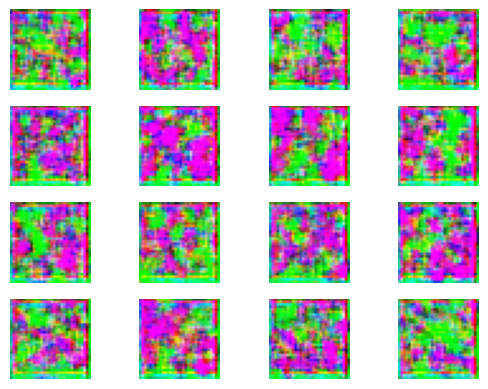

Epoch 1500/1500
Discriminator Loss: 0.11501983553171158, Real Loss = 0.11632984131574631, Fake Loss = 0.11370982974767685
Generator Loss: NA


In [34]:
train(X)

In [37]:
def plot_losses(file_name):
  _, axes = matplotlib.pyplot.subplots(figsize=(10, 5))
  axes.set_xlim([0, 1500])  # Assuming you want to plot up to 1500 epochs
  axes.set_ylim([0, 1.5])     # Adjust the range as needed

  # Read losses from file and plot
  epochs, losses_real, losses_fake, losses_avg, losses_gen = [], [], [], [], []
  with open(file_name, "r") as file:
      next(file)  # Skip the header
      for line in file:
          epoch, loss_real, loss_fake, loss_avg, loss_gen = line.strip().split(',')
          epochs.append(int(epoch))
          losses_real.append(float(loss_real))
          losses_fake.append(float(loss_fake))
          losses_avg.append(float(loss_avg))
          losses_gen.append(float(loss_gen) if loss_gen != "NA" else None)

  axes.plot(epochs, losses_real, label='Discriminator Loss - Real')
  axes.plot(epochs, losses_fake, label='Discriminator Loss - Fake')
  axes.plot(epochs, losses_avg, label='Discriminator Loss - Average')
  if any(losses_gen):
      axes.plot(epochs, losses_gen, label='Generator Loss')
  axes.set_xlabel('Epoch')
  axes.set_ylabel('Loss')
  axes.set_title('Training Losses')
  axes.legend()

  matplotlib.pyplot.show()

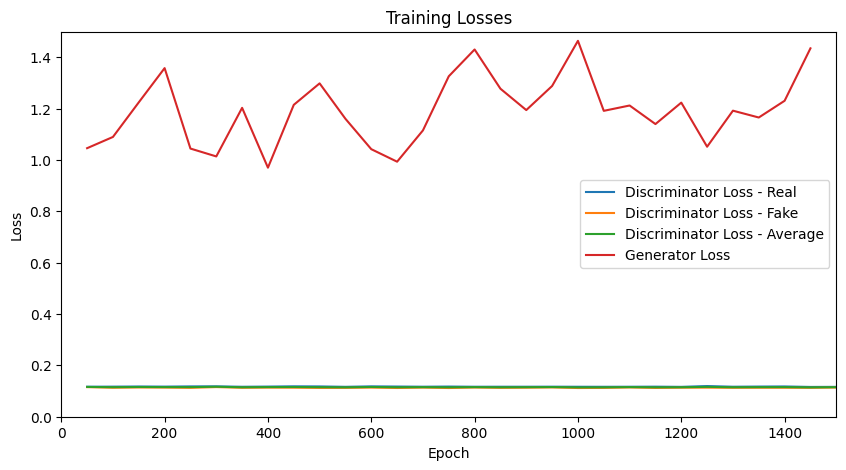

In [38]:
plot_losses("losses_1715176087.4044735.txt")

In [ ]:
# example = tensorflow.Tensor()

# example
# tf.expand_dims(image, axis=0)
example_batch = numpy.expand_dims(X[0], axis=0)
# example = tensorflow.convert_to_tensor(example_batch, numpy.float32)



# X[0] is REAL
# discriminator returned 0.00209925.

discriminator(example_batch)[0][0]



In [ ]:
tensorflow.config.list_physical_devices('GPU')

In [ ]:
import pandas

# dictionary of lists
dict = {'losses_discriminator_real': losses_discriminator_real, 'losses_discriminator_fake': losses_discriminator_fake, 'losses_discriminator': losses_discriminator, 'losses_generator': losses_generator}

df = pandas.DataFrame(dict)
df

In [ ]:
(X[0] + 1) * 127.5


In [1]:
import sys

if 'ipykernel' in sys.modules:
    # If in a Juypter notebook
    !jupyter nbconvert --to script working_with_a_generative_adversarial_network_240508_1454.ipynb

[NbConvertApp] Converting notebook working_with_a_generative_adversarial_network_240508_1454.ipynb to script
[NbConvertApp] Writing 12363 bytes to working_with_a_generative_adversarial_network_240508_1454.py
